# Fast-food Analysis

As we have studied if the nutritional informations of the average product per area were correlated to the wellbeing features, we now want to study the correlation between the nutrients composition and the number of fast foods per area.

We were able to find the database from the Londonian data website, the same one as for the wellbeing features. 

In [1]:
# Imports
from utils import calculate_nutripoints
from sklearn.cluster import KMeans, DBSCAN
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve, r2_score
from sklearn.feature_selection import RFE
import math
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_theme()

## I) Data Preparation 

### A) Data imports

In [3]:
# Data Imports

#year_grocery = pd.read_csv("data/year_osward_grocery.csv")
#display(year_grocery.head())

fast_food = pd.read_excel(
    "data/fast_food_ward.xlsx", sheet_name="Ward Data", header=[3], usecols="E,G")
display(fast_food.head())
print(fast_food.shape)

grocery_analysis = pd.read_pickle("data/grocery_nutripoints.pkl")
display(grocery_analysis.head())
print(grocery_analysis.shape)

,2015 Ward code,Count of outlets
0,E05001767,10
1,E05001768,10
2,E05001769,22
3,E05001770,81
4,E05001771,5


(5832, 2)


,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5,4
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0,1
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0,0
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0,4
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5,4


(510, 12)


### B) Merging

We compare the number of lines of grocery and fast food and try to see how many they have in common. We then merge the two datasets.

In [4]:
boolean = not grocery_analysis["area_id"].is_unique      # True (credit to @Carsten)
print(boolean)

False


In [5]:
len(set(grocery_analysis["area_id"].values))

510

In [16]:
grocery_analysis.isna().any()

area_id                 False
energy_fat              False
energy_saturate         False
energy_sugar            False
energy_protein          False
energy_carb             False
energy_fibre            False
energy_alcohol          False
energy_tot              False
h_nutrients_calories    False
nutripoints             False
nutri_class             False
dtype: bool

In [6]:
len(set(fast_food["2015 Ward code"].values))

5832

In [15]:
fast_food.isna().any()

2015 Ward code      False
Count of outlets    False
dtype: bool

In [17]:
fast_food.isnull().any()

2015 Ward code      False
Count of outlets    False
dtype: bool

In [13]:
len(set(fast_food["2015 Ward code"].values)
    & set(grocery_analysis["area_id"].values))

440

We loose 70 values by merging.  

In [14]:
fastfood_grocery = pd.merge(
    left=grocery_analysis, right=fast_food, left_on='area_id', right_on="2015 Ward code")
fastfood_grocery = fastfood_grocery.drop("2015 Ward code", axis=1)
display(fastfood_grocery.head())
print(fastfood_grocery.shape)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,Count of outlets
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0,0,15
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0,4,13
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5,4,8
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,9.0,4,14
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,9.0,4,25


(440, 13)


## II) Comprehension of the data

### A) Distribution of the values: describe, boxplot, distplot

In [19]:
#Understanding better how the values are distributed
fastfood_grocery.describe()

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,Count of outlets
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,80.653871,31.811113,40.031539,21.093016,71.787149,3.027993,1.679636,178.241665,1.573155,9.256818,1.752273,14.397727
std,2.909051,1.388606,3.306468,0.855441,5.520788,0.117759,0.364883,7.281531,0.025258,1.365437,1.656077,13.933081
min,67.111854,26.173163,30.149908,17.596480,52.921834,2.750710,0.715793,147.541243,1.465237,5.000000,0.000000,1.000000
25%,78.989452,30.955484,37.927397,20.696160,68.159543,2.947692,1.433929,173.856481,1.556885,8.500000,0.000000,7.000000
50%,80.448641,31.660923,39.643719,21.229909,71.872886,3.022663,1.660522,178.583441,1.573913,9.000000,1.000000,11.000000
75%,82.164445,32.544245,42.018439,21.675982,75.687417,3.093645,1.873801,182.536718,1.590158,10.000000,4.000000,18.000000
max,92.440804,38.690892,48.719140,23.005837,84.618879,3.617668,3.490972,197.674474,1.680088,14.500000,4.000000,147.000000


<AxesSubplot:ylabel='Count of outlets'>

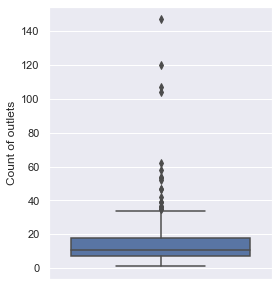

In [27]:
fig = plt.figure(figsize=(4, 5))

sns.boxplot(y=fastfood_grocery_analysis["Count of outlets"])


They are many outliers for the number of outlets going up to 147 whereas the median is at 11. Due to this phenomenom, the mean is quite high whereas half 75% of the values are between 1 and 18. 

Text(0.5, 0.98, 'histplot for each column')

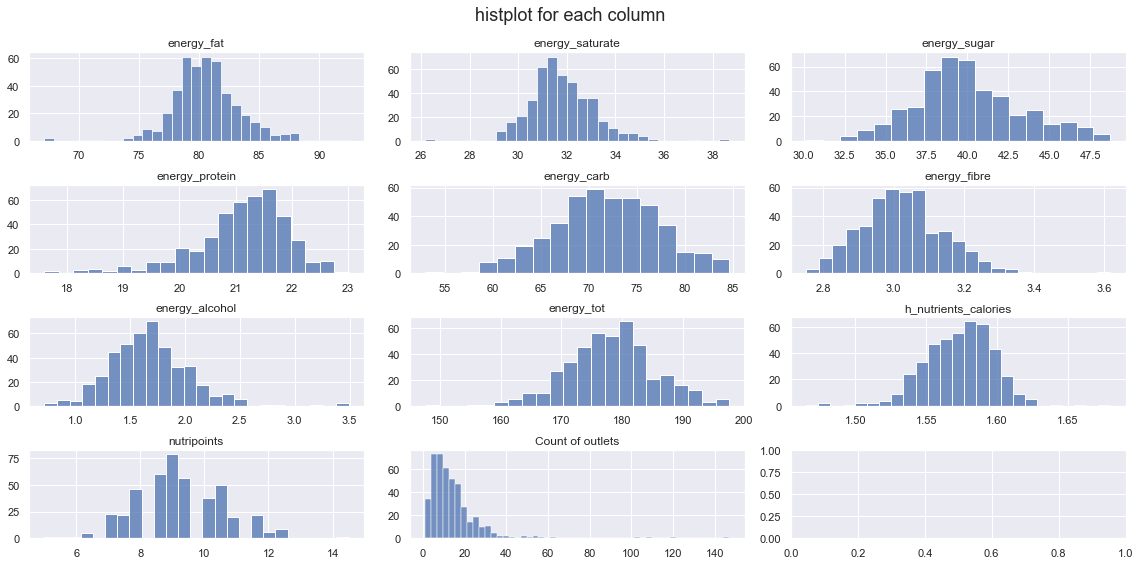

In [28]:
fig, ax = plt.subplots(4, 3, figsize=(16, 8), sharey=False)

for i in range(len(column_boxplot)):
    sbplt = ax[int(i/3), i % 3]

    sns.histplot(data=fastfood_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(fastfood_grocery_analysis.columns[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('histplot for each column', fontsize=18)

Most of the nutritional variables seem to be normally distributed. On the other side, the number of outlets is more logarithmic. Most of the areas have between 5 and 10 fast foods but it go to 140! 

### B) Correlation between the number of fast food and the different nutritional variables

<AxesSubplot:>

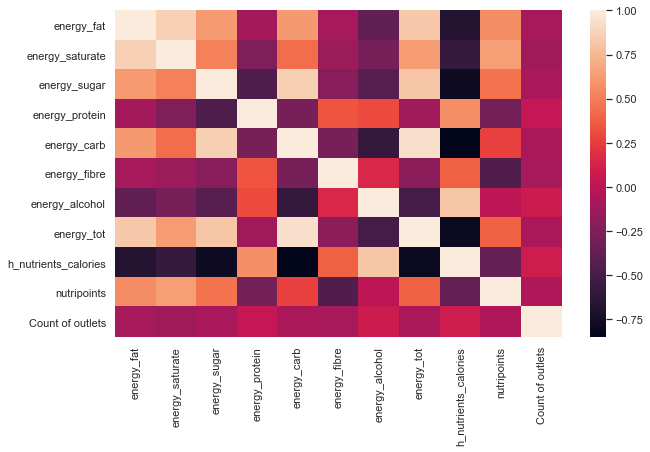

In [29]:
# Heatmap to visualize the correlation between the variables
fig = plt.figure(figsize=(10, 6))
sns.heatmap(fastfood_grocery_analysis.corr())

The correlation with the number of oulets (the last column or row) seems really low as the colours are mainly red, corresponding to values around 0. We will display the correlation table for the count of outlets to better understand the importance of the correlation with the nutritional variables. 

In [35]:
correlation = fastfood_grocery_analysis.corr(method="spearman")
display(correlation[["Count of outlets"]])

,Count of outlets
energy_fat,-0.010292
energy_saturate,-0.105991
energy_sugar,-0.012535
energy_protein,0.052572
energy_carb,0.034797
energy_fibre,-0.213410
energy_alcohol,0.000670
energy_tot,0.028182
h_nutrients_calories,-0.018201
nutripoints,0.007811


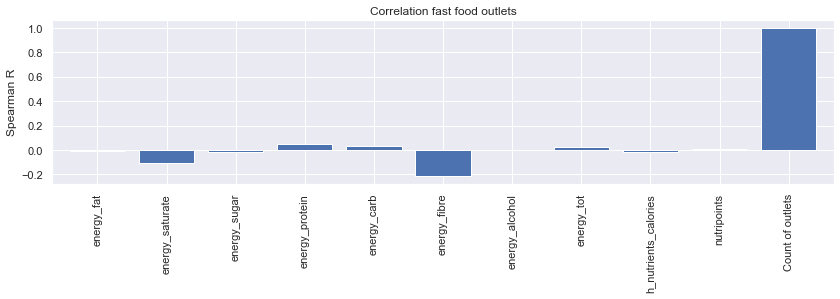

In [32]:
plt.figure(figsize=(14, 3))
correlation["Count of outlets"].plot.bar(
    x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation fast food outlets")
plt.show()

The number of fast food is not at all correlated with the nutripoints. Furthermore, there is almost no correlation with other variables. Therefore, it is hardly justifiable to predict the nutritional informations of the avergae product of an area from the number of fast food.

We will however try to further investigate this correlation. 

## Regression Analysis

### A) Linear Regression of nutripoints from the number of fastfood

In [46]:
# Understanding the linear regression between the two variables
Y = fastfood_grocery[["nutripoints"]]
X1 = fastfood_grocery[["Count of outlets"]]
X = sm.add_constant(X1)  # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            nutripoints   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6930
Date:                Sun, 13 Dec 2020   Prob (F-statistic):              0.406
Time:                        18:20:47   Log-Likelihood:                -760.53
No. Observations:                 440   AIC:                             1525.
Df Residuals:                     438   BIC:                             1533.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.3129      0.094  

The R-squared is very small: 0.002, meaning we can only predict 0.2% of our nutripoints from the number of fast food. Furthermore, the coeeficient of this latter is neglectable as it is -0.0039, the intercept is the one having the more weight in this regression. Therefore, we can conclude that the Linear Regression is not the adapted regression for prediction of nutripoints of each area from the number of fastfood. It actually makes sense as there was almost no correlation between these two variables, it is actually difficult to predict one from the other. 

### B) Gradient boosting Regressor

We know that there is almost no correlation and that the Linear Regression is not representative at all. However, we still wanted to explore if another type of regression: the Gradient Boosting method, would be more concluent. 

In [47]:
# train a gradient boosting regressor
gradboost = GradientBoostingRegressor()

In [51]:
y=fastfood_grocery["nutripoints"]
predicted_y = cross_val_predict(gradboost, X, y, cv=5)

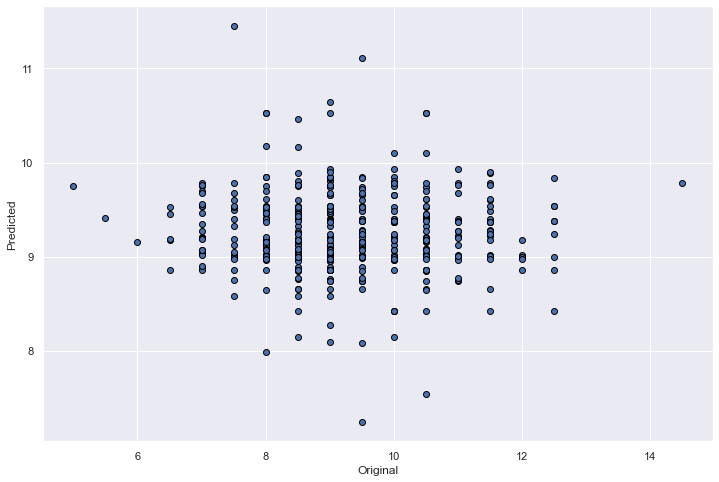

In [52]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(Y, predicted_y, edgecolors=(0, 0, 0))
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

If the prediction was representative of the nutripoints, we should observe a diagonal line, it is not what we have at all. This means that for a certain nutripoints, the predicted one from the Gradient Boosting Regression is higher or smaller than the original value. 

To confirm this assumption, we compute the mean squared error and the R-squared value:

In [50]:
r2 = r2_score(Y, predicted_y)
mse = mean_squared_error(Y, predicted_y)
print(r2, mse)

-0.12766332059740226 2.0976576410643757


The R-squared is very small and negative. A horizontal line would actually be more representative of our regression. Furthermore, the mean squared error is very high. The regression is therefore not representative neither of our nutripoints variable. 

## Conclusion 

As the correlation predicted it, it is not possible to find a good regression in order to predict the nutripoints from the number of fast food of an area. Indeed, there are almost not correlated making it difficult to have high coefficient for our regressions. 

Having the average products per area, actually, makes it difficult to have a representation of how healthy the inhabitants of an area consume. A high nutripoint doesn't necessary mean that the consumers of this area consume more fatty or sugary products. Furthermore, an unheleathy average product is not linked to a high number of fastfoods. However, it could be interesting to see if the richest areas have less fast foods making the assumption that the inhabitants would prefer to go in a real restaurant.  